# Yao Yao

Patientfi Data Challenge

### You will find a file labeled data.csv in the link that contains loan data including the credit attributes and loan status, etc. Your goal is to predict the likelihood of a loan to “charge off” (column “loan_status“).  

### The credit default prediction is central to managing risk in a consumer lending business, as it allows lenders to optimize lending decisions. You’ll apply your machine learning skills to predict credit default by the dataset we provided to you. You're free to explore any techniques to create the most powerful model, from creating features to using the data in a more organic way within a model. 

### Please build your model with a detailed description/explanation, as it will help us understand and evaluate how you approach the problem.

In [1]:
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True
if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from datetime import datetime
import time
from sklearn.model_selection import KFold, StratifiedKFold
import itertools
import os
from PIL import Image
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

%matplotlib inline

# Import data and create data summary

In [2]:
df=pd.read_csv("data.csv", engine = 'c')

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,199999.0,6.229635e+07,3.941126e+06,56705.00,59411733.00,62217538.00,65644568.00,68617057.00
member_id,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,199999.0,1.527812e+04,8.651139e+03,1000.00,8500.00,14000.00,20000.00,35000.00
funded_amnt,199999.0,1.527812e+04,8.651139e+03,1000.00,8500.00,14000.00,20000.00,35000.00
funded_amnt_inv,199999.0,1.526947e+04,8.646325e+03,900.00,8475.00,14000.00,20000.00,35000.00
...,...,...,...,...,...,...,...,...
hardship_payoff_balance_amount,1409.0,1.001451e+04,6.313702e+03,55.73,4708.77,8879.16,14383.87,29401.04
hardship_last_payment_amount,1409.0,1.860614e+02,1.812045e+02,0.02,44.95,134.56,275.29,927.79
settlement_amount,5840.0,5.015406e+03,3.557532e+03,130.00,2192.49,4344.99,7000.00,26242.50
settlement_percentage,5840.0,4.710027e+01,5.753855e+00,20.00,45.00,45.00,50.00,97.66


In [4]:
df.isnull().T.any().T.sum()

199999

# Given that there are a lot of values missing, remove columns that have over 80% missing for the sake of the exercise and time. 'Default' for loan status is removed because it only has one result

In [5]:
df = df[df.columns[df.isnull().mean() < 0.8]]
df = df[df.columns[df.isna().mean() < 0.8]]
df = df[df['loan_status']!='Default'].reset_index(drop=True)
df

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,68407277,3600,3600,3600.0,36 months,13.99,123.03,C,C4,leadman,...,0.0,0,0,178050,7746,2400,13734,N,Cash,N
1,68355089,24700,24700,24700.0,36 months,11.99,820.28,C,C1,Engineer,...,7.7,0,0,314017,39475,79300,24667,N,Cash,N
2,68341763,20000,20000,20000.0,60 months,10.78,432.66,B,B4,truck driver,...,50.0,0,0,218418,18696,6200,14877,N,Cash,N
3,66310712,35000,35000,35000.0,60 months,14.85,829.90,C,C5,Information Systems Officer,...,0.0,0,0,381215,52226,62500,18000,N,Cash,N
4,68476807,10400,10400,10400.0,60 months,22.45,289.91,F,F1,Contract Specialist,...,60.0,0,0,439570,95768,20300,88097,N,Cash,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,56059770,4000,4000,4000.0,36 months,12.29,133.42,C,C1,Teacher,...,83.3,0,0,194282,29295,24400,7000,N,Cash,N
199994,56080425,12000,12000,12000.0,36 months,12.69,402.54,C,C2,Truck driver,...,50.0,0,0,32176,27413,13800,5784,N,Cash,N
199995,55909672,21000,21000,21000.0,36 months,12.29,700.42,C,C1,Attorney,...,100.0,0,0,181446,173683,15000,157346,N,Cash,N
199996,54414556,27500,27500,27500.0,60 months,14.65,649.19,C,C5,hvac tech,...,0.0,0,0,53653,30750,18500,35153,N,Cash,N


In [6]:
df.isnull().T.any().T.sum()

176141

In [7]:
#df.to_csv('df.csv',index=False)

# Convert certain strings into continuous variables

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,199998.0,6.229633e+07,3.941125e+06,56705.00,59411731.00,62217530.00,65644565.25,68617057.00
loan_amnt,199998.0,1.527802e+04,8.651048e+03,1000.00,8500.00,14000.00,20000.00,35000.00
funded_amnt,199998.0,1.527802e+04,8.651048e+03,1000.00,8500.00,14000.00,20000.00,35000.00
funded_amnt_inv,199998.0,1.526937e+04,8.646234e+03,900.00,8475.00,14000.00,20000.00,35000.00
int_rate,199998.0,1.236171e+01,4.242075e+00,5.32,9.17,12.29,14.65,28.99
...,...,...,...,...,...,...,...,...
tax_liens,199998.0,6.433564e-02,4.656492e-01,0.00,0.00,0.00,0.00,85.00
tot_hi_cred_lim,199998.0,1.770256e+05,1.779942e+05,2500.00,52205.00,115187.50,255110.50,9999999.00
total_bal_ex_mort,199998.0,5.281753e+04,4.949148e+04,0.00,22736.00,40069.00,66654.50,2652799.00
total_bc_limit,199998.0,2.258573e+04,2.234689e+04,0.00,8000.00,15700.00,29500.00,834300.00


# Convert term into continuous variable

In [9]:
df['term'] = df['term'].str[:3].astype('int')
df['term']

0         36
1         36
2         60
3         60
4         60
          ..
199993    36
199994    36
199995    36
199996    60
199997    36
Name: term, Length: 199998, dtype: int32

# Make Grade numeric multiplied by 10, and Sub Grade numeric multiplied by 2 minus 2 to keep it at scale

In [10]:
df['grade'] = df['grade'].to_numpy().astype('<U1').view(np.uint32)-64
df['grade']

0         3
1         3
2         2
3         3
4         6
         ..
199993    3
199994    3
199995    3
199996    3
199997    2
Name: grade, Length: 199998, dtype: uint32

In [11]:
df['sub_grade'] = df['sub_grade'].str[1:].astype('int')*2-2
df['sub_grade']

0         6
1         0
2         6
3         8
4         0
         ..
199993    0
199994    2
199995    0
199996    8
199997    6
Name: sub_grade, Length: 199998, dtype: int32

In [12]:
df['grade'] = df['grade']*10+df['sub_grade']
df['grade']

0         36
1         30
2         26
3         38
4         60
          ..
199993    30
199994    32
199995    30
199996    38
199997    26
Name: grade, Length: 199998, dtype: int64

# Make the titles lowercase, trim whitespace, and then make dummy variables for the words separated by space later

In [13]:
df['emp_title'] = df['emp_title'].str.lower().str.strip()
df['emp_title']

0                             leadman
1                            engineer
2                        truck driver
3         information systems officer
4                 contract specialist
                     ...             
199993                        teacher
199994                   truck driver
199995                       attorney
199996                      hvac tech
199997         nursing office manager
Name: emp_title, Length: 199998, dtype: object

make the length of the career numeric, simplified

# Change length of title to numerical

In [14]:
df['emp_length'] = df['emp_length'].str.split(' ', 1, expand=True)[0].str.extract('(\d+)', expand=False).replace('None', np.nan).astype('float')
df['emp_length']

0         10.0
1         10.0
2         10.0
3         10.0
4          3.0
          ... 
199993    10.0
199994     1.0
199995     8.0
199996    10.0
199997     7.0
Name: emp_length, Length: 199998, dtype: float64

# Zip code can be converted into numeric given there that is a pattern in geo labeling 

In [15]:
df['zip_code'] = df['zip_code'].str[:3].replace('None', np.nan).astype('int')
df['zip_code']

0         190
1         577
2         605
3          76
4         174
         ... 
199993    850
199994    983
199995    113
199996    983
199997    846
Name: zip_code, Length: 199998, dtype: int32

# Convert the dates into datetime format

In [16]:
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%y')
df['earliest_cr_line']

0        2003-08-01
1        1999-12-01
2        2000-08-01
3        2008-09-01
4        1998-06-01
            ...    
199993   1997-06-01
199994   2003-09-01
199995   2001-10-01
199996   2002-06-01
199997   1990-11-01
Name: earliest_cr_line, Length: 199998, dtype: datetime64[ns]

In [17]:
df['earliest_cr_line'].min()

Timestamp('1969-01-01 00:00:00')

In [18]:
df['last_credit_pull_d'] = pd.to_datetime(df['last_credit_pull_d'], format='%b-%y')
df['last_credit_pull_d']

0        2019-03-01
1        2019-03-01
2        2019-03-01
3        2019-03-01
4        2018-03-01
            ...    
199993   2019-02-01
199994   2016-02-01
199995   2018-09-01
199996   2016-02-01
199997   2019-03-01
Name: last_credit_pull_d, Length: 199998, dtype: datetime64[ns]

In [19]:
df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%y')
df['last_pymnt_d']

0        2019-01-01
1        2016-06-01
2        2017-06-01
3        2019-02-01
4        2016-07-01
            ...    
199993   2018-06-01
199994   2016-01-01
199995   2018-08-01
199996   2016-03-01
199997   2018-08-01
Name: last_pymnt_d, Length: 199998, dtype: datetime64[ns]

# Earliest credit line, credit pull, and last payment dates are less arbritray when relative to each other, so I made new columns showing the difference in days among those dates

In [20]:
df['diff credit pull credit line'] = (df['last_credit_pull_d'] - df['earliest_cr_line']).dt.days
df['diff credit pull credit line'] 

0          5691.0
1          7030.0
2          6786.0
3          3833.0
4          7213.0
           ...   
199993     7915.0
199994     4536.0
199995     6179.0
199996     4993.0
199997    10347.0
Name: diff credit pull credit line, Length: 199998, dtype: float64

In [21]:
df['diff payment credit line'] = (df['last_pymnt_d'] - df['earliest_cr_line']).dt.days
df['diff payment credit line'] 

0          5632.0
1          6027.0
2          6148.0
3          3805.0
4          6605.0
           ...   
199993     7670.0
199994     4505.0
199995     6148.0
199996     5022.0
199997    10135.0
Name: diff payment credit line, Length: 199998, dtype: float64

In [22]:
df['diff credit pull payment'] = (df['last_credit_pull_d'] - df['last_pymnt_d']).dt.days
df['diff credit pull payment']

0           59.0
1         1003.0
2          638.0
3           28.0
4          608.0
           ...  
199993     245.0
199994      31.0
199995      31.0
199996     -29.0
199997     212.0
Name: diff credit pull payment, Length: 199998, dtype: float64

# converted datetime to year month on the same scale

In [23]:
df['earliest_cr_line'] = pd.DatetimeIndex(df['earliest_cr_line']).year * 100 + (pd.DatetimeIndex(df['earliest_cr_line']).month - 1)* 100/12
df['earliest_cr_line']

0         200358.333333
1         199991.666667
2         200058.333333
3         200866.666667
4         199841.666667
              ...      
199993    199741.666667
199994    200366.666667
199995    200175.000000
199996    200241.666667
199997    199083.333333
Name: earliest_cr_line, Length: 199998, dtype: float64

# Converted month and year into one continuous variable

In [24]:
df['last_credit_pull_d'] = pd.DatetimeIndex(df['last_credit_pull_d']).year * 100 + (pd.DatetimeIndex(df['last_credit_pull_d']).month - 1)* 100/12
df['last_credit_pull_d']

0         201916.666667
1         201916.666667
2         201916.666667
3         201916.666667
4         201816.666667
              ...      
199993    201908.333333
199994    201608.333333
199995    201866.666667
199996    201608.333333
199997    201916.666667
Name: last_credit_pull_d, Length: 199998, dtype: float64

In [25]:
df['last_pymnt_d'] = pd.DatetimeIndex(df['last_pymnt_d']).year * 100 + (pd.DatetimeIndex(df['last_pymnt_d']).month - 1)* 100/12
df['last_pymnt_d']

0         201900.000000
1         201641.666667
2         201741.666667
3         201908.333333
4         201650.000000
              ...      
199993    201841.666667
199994    201600.000000
199995    201858.333333
199996    201616.666667
199997    201858.333333
Name: last_pymnt_d, Length: 199998, dtype: float64

# Sub grade was combined into grade. funded amount is redundant to loan amount. issue date, and distribution method have no variance, so they are dropped

In [26]:
df = df.drop(columns = ['issue_d','sub_grade','disbursement_method','funded_amnt']).fillna(-1)
df

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,emp_length,home_ownership,...,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag,diff credit pull credit line,diff payment credit line,diff credit pull payment
0,68407277,3600,3600.0,36,13.99,123.03,36,leadman,10.0,MORTGAGE,...,0,178050,7746,2400,13734,N,N,5691.0,5632.0,59.0
1,68355089,24700,24700.0,36,11.99,820.28,30,engineer,10.0,MORTGAGE,...,0,314017,39475,79300,24667,N,N,7030.0,6027.0,1003.0
2,68341763,20000,20000.0,60,10.78,432.66,26,truck driver,10.0,MORTGAGE,...,0,218418,18696,6200,14877,N,N,6786.0,6148.0,638.0
3,66310712,35000,35000.0,60,14.85,829.90,38,information systems officer,10.0,MORTGAGE,...,0,381215,52226,62500,18000,N,N,3833.0,3805.0,28.0
4,68476807,10400,10400.0,60,22.45,289.91,60,contract specialist,3.0,MORTGAGE,...,0,439570,95768,20300,88097,N,N,7213.0,6605.0,608.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,56059770,4000,4000.0,36,12.29,133.42,30,teacher,10.0,MORTGAGE,...,0,194282,29295,24400,7000,N,N,7915.0,7670.0,245.0
199994,56080425,12000,12000.0,36,12.69,402.54,32,truck driver,1.0,RENT,...,0,32176,27413,13800,5784,N,N,4536.0,4505.0,31.0
199995,55909672,21000,21000.0,36,12.29,700.42,30,attorney,8.0,RENT,...,0,181446,173683,15000,157346,N,N,6179.0,6148.0,31.0
199996,54414556,27500,27500.0,60,14.65,649.19,38,hvac tech,10.0,RENT,...,0,53653,30750,18500,35153,N,N,4993.0,5022.0,-29.0


In [27]:
df.isna().any().sum()

0

# Summary of variables after clean up

In [28]:
df.describe()

,id,loan_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,annual_inc,zip_code,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,diff credit pull credit line,diff payment credit line,diff credit pull payment
count,1.999980e+05,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,199998.000000,1.999980e+05,199998.000000,...,199998.000000,199998.000000,199998.000000,1.999980e+05,1.999980e+05,199998.000000,1.999980e+05,199998.000000,199998.000000,199998.000000
mean,6.229633e+07,15278.018530,15269.374289,43.842678,12.361711,441.381145,31.132161,5.509750,7.815054e+04,507.370864,...,46.015581,0.132301,0.064336,1.770256e+05,5.281753e+04,22585.728182,4.413560e+04,7116.756833,6838.951250,273.524955
std,3.941125e+06,8651.048016,8646.233566,11.256878,4.242075,247.050693,12.686827,4.106834,8.051398e+04,309.216121,...,36.389153,0.384264,0.465649,1.779942e+05,4.949148e+04,22346.885365,4.447859e+04,3029.208281,3054.193244,313.447481
min,5.670500e+04,1000.000000,900.000000,36.000000,5.320000,14.770000,10.000000,-1.000000,0.000000e+00,7.000000,...,-1.000000,0.000000,0.000000,2.500000e+03,0.000000e+00,0.000000,0.000000e+00,-19390.000000,-19390.000000,-1308.000000
25%,5.941173e+07,8500.000000,8475.000000,36.000000,9.170000,261.880000,22.000000,2.000000,4.756650e+04,231.000000,...,11.100000,0.000000,0.000000,5.220500e+04,2.273600e+04,8000.000000,1.585025e+04,5264.000000,4960.000000,0.000000
50%,6.221753e+07,14000.000000,14000.000000,36.000000,12.290000,383.810000,30.000000,6.000000,6.500000e+04,468.000000,...,50.000000,0.000000,0.000000,1.151875e+05,4.006900e+04,15700.000000,3.357550e+04,6664.000000,6390.000000,181.000000
75%,6.564457e+07,20000.000000,20000.000000,60.000000,14.650000,580.730000,38.000000,10.000000,9.340000e+04,797.000000,...,75.000000,0.000000,0.000000,2.551105e+05,6.665450e+04,29500.000000,5.921300e+04,8644.000000,8401.000000,457.000000
max,6.861706e+07,35000.000000,35000.000000,60.000000,28.990000,1445.460000,78.000000,10.000000,9.000000e+06,999.000000,...,100.000000,9.000000,85.000000,9.999999e+06,2.652799e+06,834300.000000,2.101913e+06,18321.000000,18262.000000,1311.000000


In [29]:
df[df.columns[df.dtypes == "O"]].describe().T

,count,unique,top,freq
emp_title,199998,53276,-1,12130
home_ownership,199998,4,MORTGAGE,99617
verification_status,199998,3,Source Verified,84755
loan_status,199998,6,Fully Paid,140991
pymnt_plan,199998,2,n,199976
addr_state,199998,49,CA,27304
initial_list_status,199998,2,w,142654
application_type,199998,2,Individual,199487
hardship_flag,199998,2,N,199967
debt_settlement_flag,199998,2,N,194158


# For the sake of the exercise, if the title appears 200 times, which is 1/1000 of the dataset, create a dummy variable for that title

In [30]:
len(df)/1000

199.998

In [31]:
counts = pd.value_counts(df['emp_title'])
mask = df['emp_title'].isin(counts[counts > 200].index)
dummies = pd.get_dummies(df['emp_title'][mask], prefix='emp_title')
df = pd.concat([df, dummies], axis=1).fillna(0)
dummies

,emp_title_-1,emp_title_account executive,emp_title_account manager,emp_title_accountant,emp_title_accounting manager,emp_title_administrative assistant,emp_title_administrator,emp_title_analyst,emp_title_assistant manager,emp_title_associate,...,emp_title_supervisor,emp_title_teacher,emp_title_team leader,emp_title_tech,emp_title_technician,emp_title_truck driver,emp_title_underwriter,emp_title_vice president,emp_title_vp,emp_title_welder
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199986,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
199990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
199993,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
199994,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [32]:
# list(df.select_dtypes(exclude='O').columns.values)
colnames = ['term',
 'int_rate',
 'grade',
 'emp_length',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'total_rec_late_fee',
 'last_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code',
 'acc_now_delinq',
 'acc_open_past_24mths',
 'bc_open_to_buy',
 'bc_util',
 'chargeoff_within_12_mths',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'mths_since_recent_bc',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_inq',
 'mths_since_recent_revol_delinq',
 'num_accts_ever_120_pd',
 'num_actv_bc_tl',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_il_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_120dpd_2m',
 'num_tl_30dpd',
 'num_tl_90g_dpd_24m',
 'num_tl_op_past_12m',
 'pct_tl_nvr_dlq',
 'percent_bc_gt_75',
 'pub_rec_bankruptcies',
 'tax_liens']
len(colnames)

46

# For the continuous variables, plot the distribution by loan status

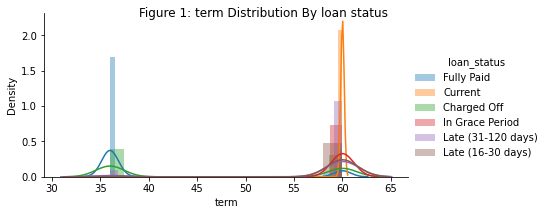

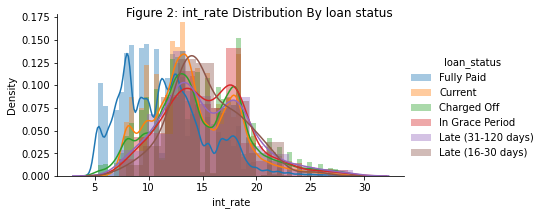

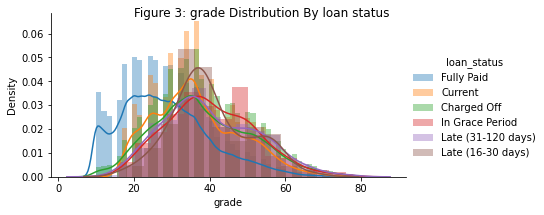

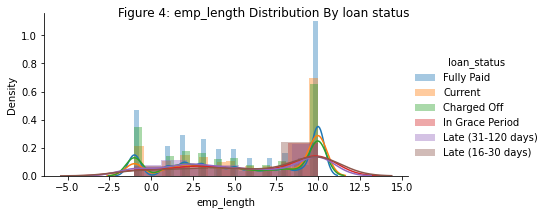

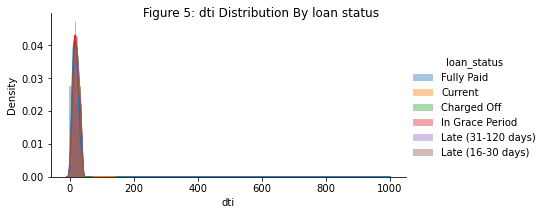

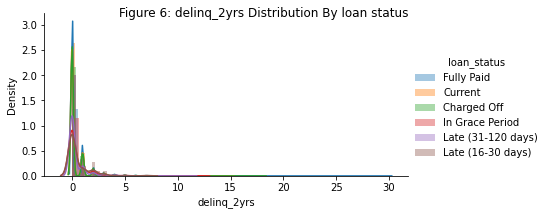

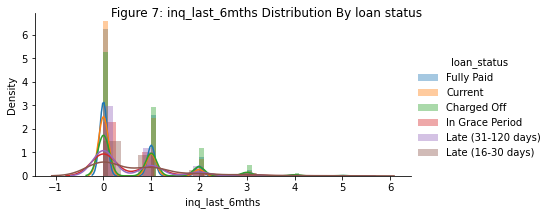

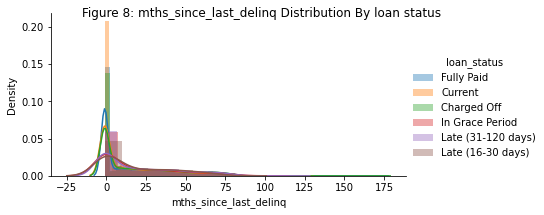

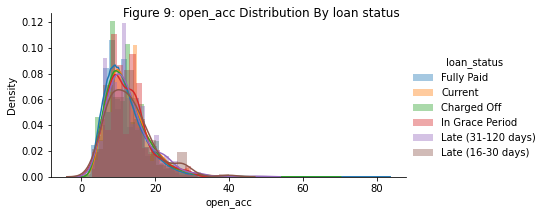

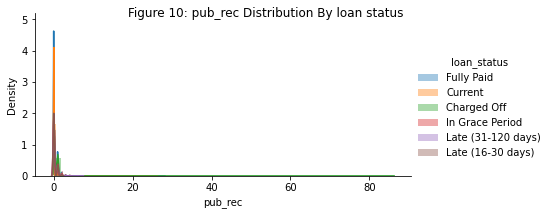

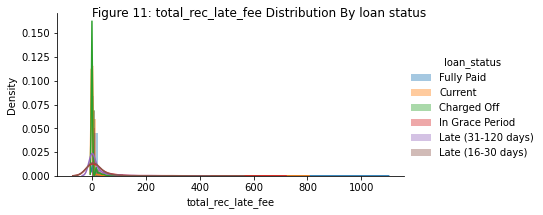

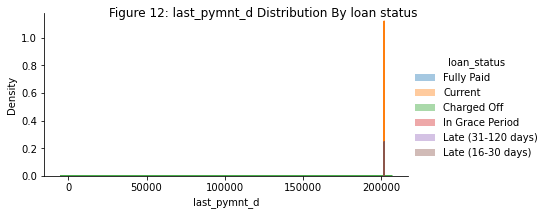

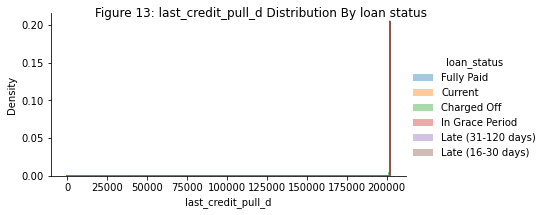

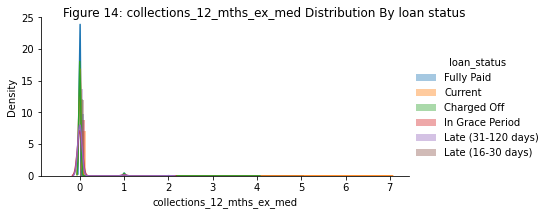

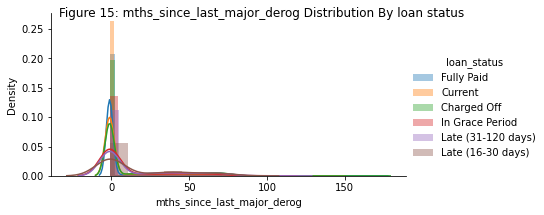

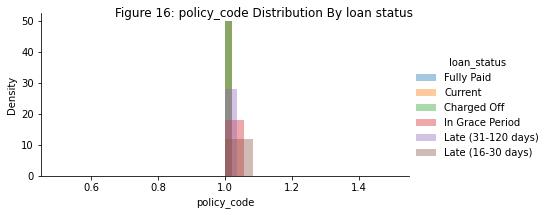

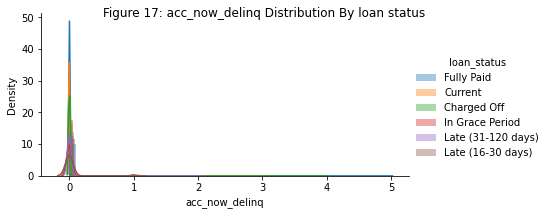

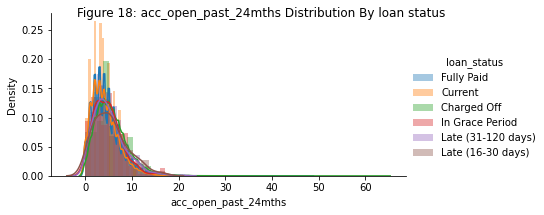

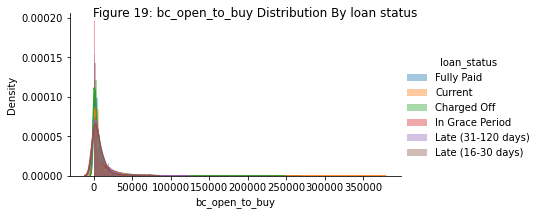

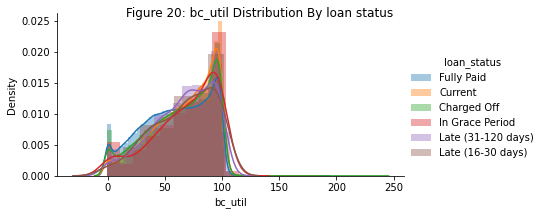

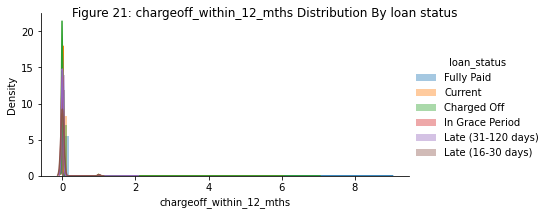

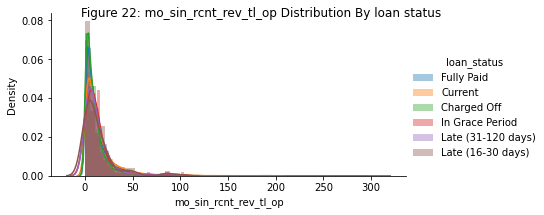

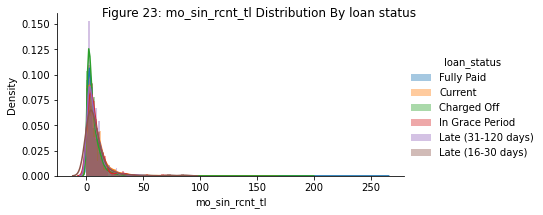

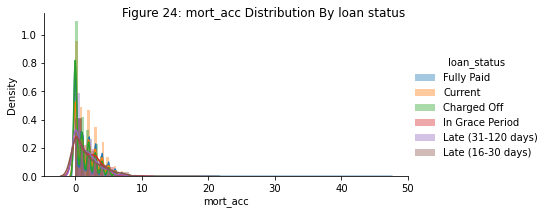

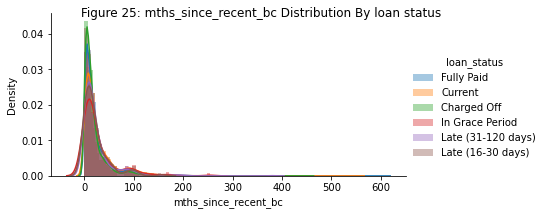

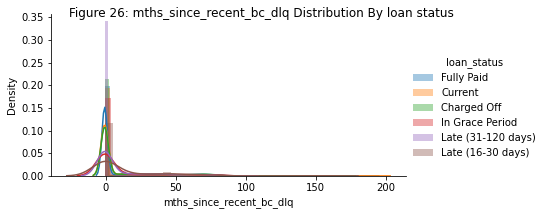

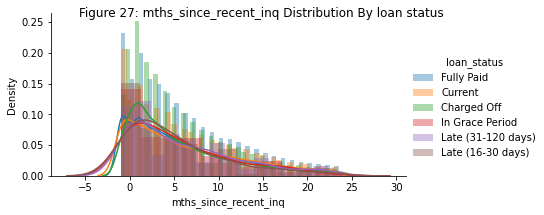

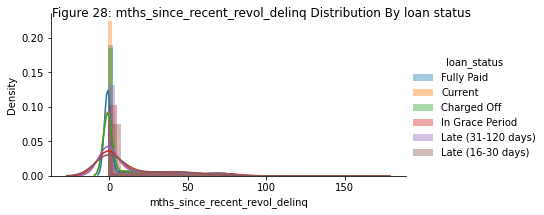

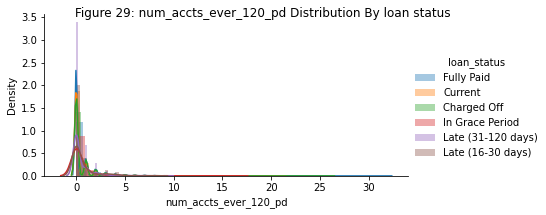

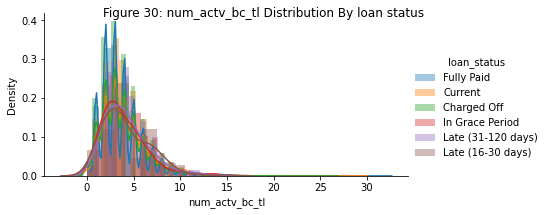

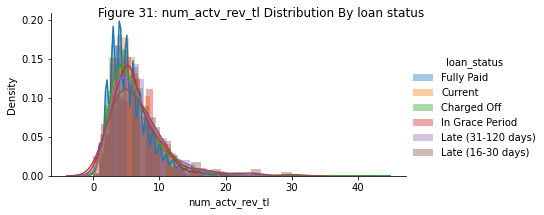

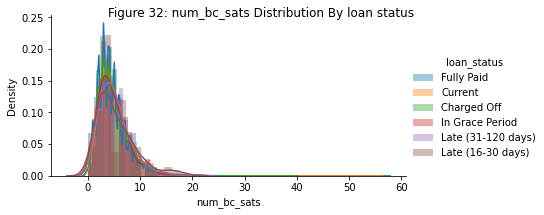

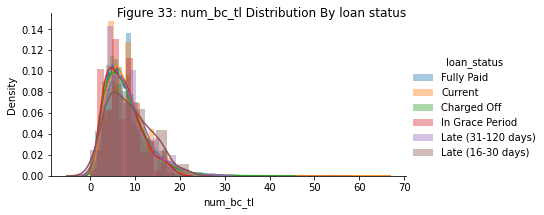

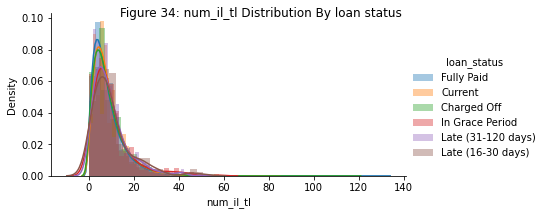

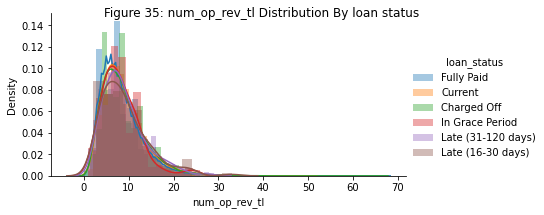

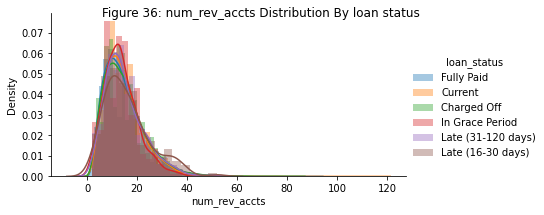

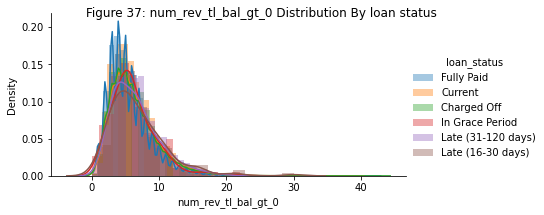

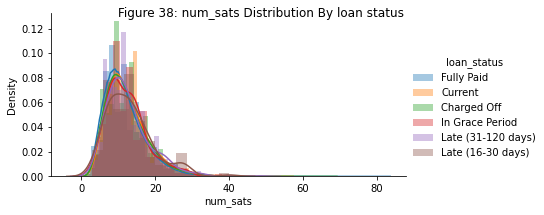

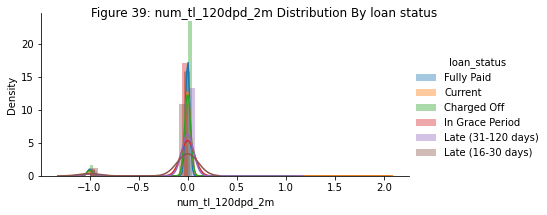

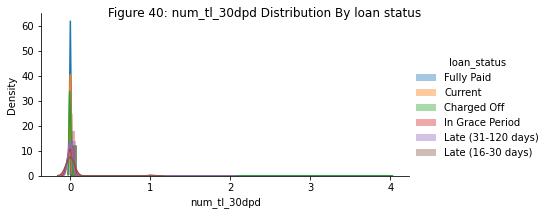

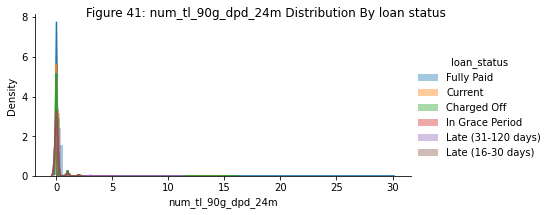

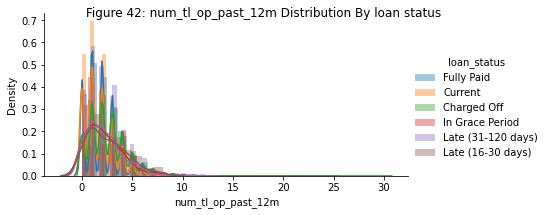

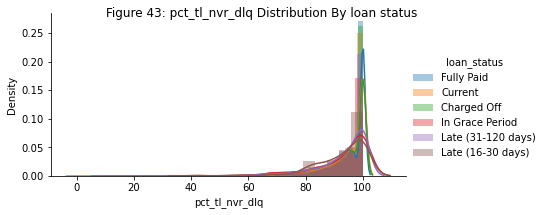

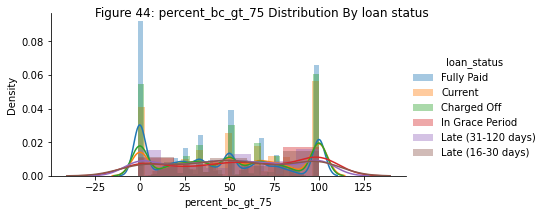

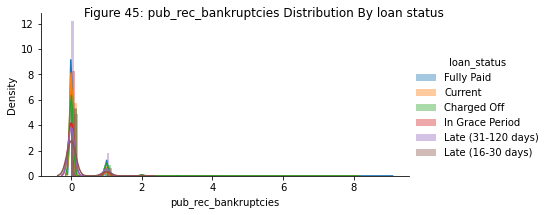

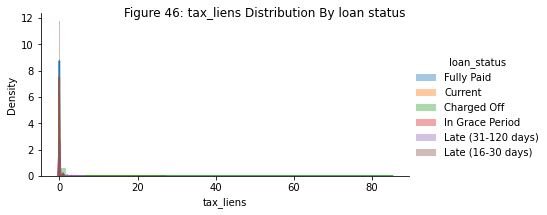

In [33]:
plt.rcParams['figure.max_open_warning']=40
# colnames=list(df.select_dtypes(exclude='O').columns.values)
for i in colnames[0:]:
    facet = sns.FacetGrid(df,hue='loan_status',aspect=2)
    facet.map(sns.distplot,i)
    facet.add_legend()
    facet.fig.suptitle(''.join(map(str, list(["Figure ",colnames.index(i)+1,": ",i," Distribution By loan status"]))))
    plt.show()

In [34]:
# colnames=list(df.select_dtypes(include='O').columns.values)
colnames=['home_ownership',
 'verification_status',
 'loan_status',
 'pymnt_plan',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'debt_settlement_flag']

# Visualization of categorical variables

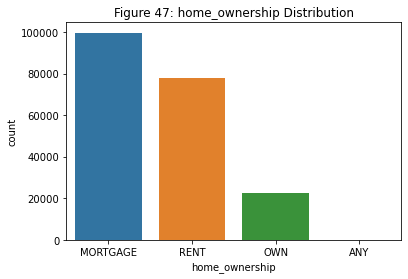

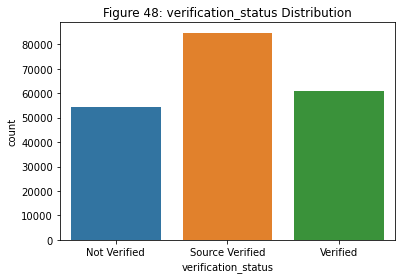

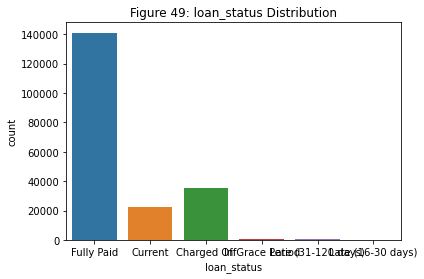

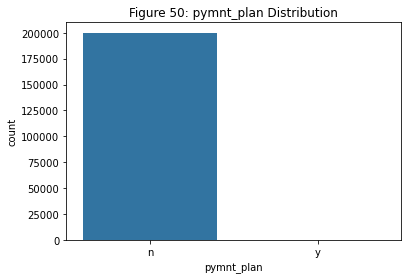

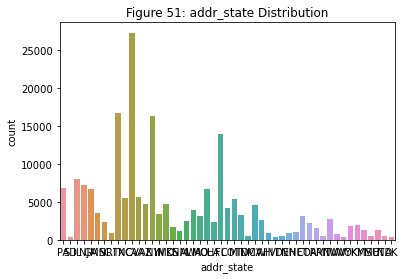

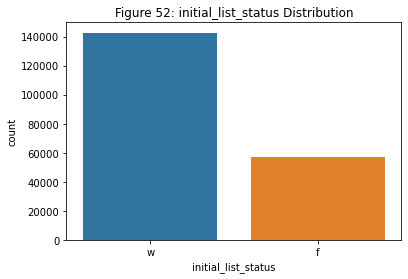

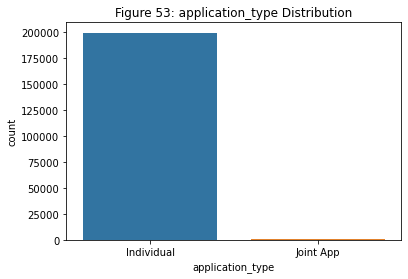

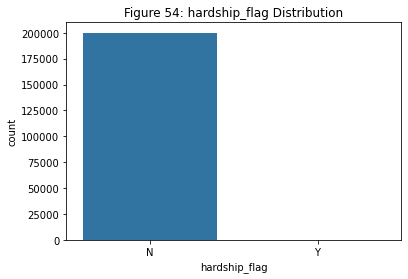

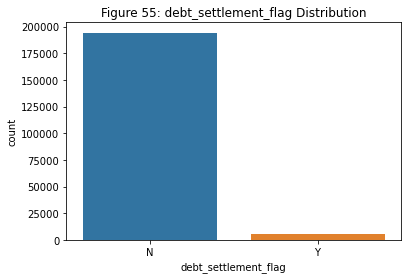

In [35]:
plt.rcParams['figure.max_open_warning']=40
# colnames=list(df.select_dtypes(include='O').columns.values)
for i in colnames[0:]:
    ax = plt.axes()
    sns.countplot(x=i, data=df, ax = ax)
    ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+47,": ",i," Distribution"]))))
    plt.show()

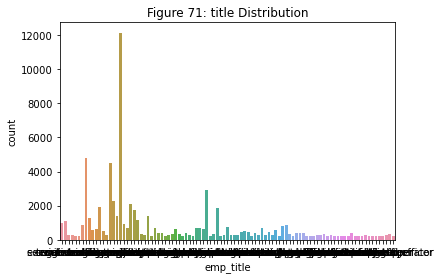

In [36]:
ax = plt.axes()
sns.countplot(x=df['emp_title'][mask], data=df, ax = ax)
ax.set_title(''.join(map(str, list(["Figure ",colnames.index(i)+63,": ",'title'," Distribution"]))))
plt.show()

# Separate the Target Variable from the rest of the dataset


In [37]:
y = df.pop('loan_status')

In [38]:
colnames.remove('loan_status')

# Make dummy variables for select categorical variables

In [39]:
for i in colnames[0:]:
    # Fill missing data with the word "Missing"
    df[i].fillna("Missing", inplace=True)
    # Create array of dummies
    dummies = pd.get_dummies(df[i], prefix=i)
    # Update X to include dummies and drop the main variable
    df = pd.concat([df, dummies], axis=1)
    df.drop([i], axis=1, inplace=True)
df.drop('emp_title', axis=1, inplace=True)

# Use minmaxscalar to scale all the dataset on a 0 to 1 scale for coefficient comparisons later for important features. Use stratified K fold with a set random state to shuffle the sampling set yet keep the results reproducible with the set random state

In [40]:
columns = df.columns
sc = MinMaxScaler(feature_range=(0, 1))
df = sc.fit_transform(df)
df = pd.DataFrame(df, columns=columns)

#x_train, x_test, y_train, y_test = train_test_split(df, y_int, test_size=0.33, random_state=2, stratify=y_int)
skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 2)

# Using a decision tree classifed with default parameters, the metrics are already very good for the metrics of precision, recall, and f1-score. Recall is type 1 errors, which is when a person is predicted not to pay and pays. Precision is type 2 errors, which is when a person is predicted to pay and does not pay. F1 score is the balance between recall and precision, while accuracy is the overall reliability of the prediction

In [41]:
model2 = DecisionTreeClassifier()

for train_idx, test_idx in skf.split(df, y):
    y_score = model2.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model2.predict(df.loc[test_idx])))

                    precision    recall  f1-score   support

       Charged Off       0.98      0.98      0.98     11697
           Current       0.97      0.97      0.97      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.06      0.08      0.07       115
 Late (16-30 days)       0.06      0.06      0.06        49
Late (31-120 days)       0.76      0.81      0.78       262

          accuracy                           0.99     66666
         macro avg       0.64      0.65      0.64     66666
      weighted avg       0.99      0.99      0.99     66666

                    precision    recall  f1-score   support

       Charged Off       0.98      0.98      0.98     11696
           Current       0.97      0.97      0.97      7546
        Fully Paid       0.99      0.99      0.99     46997
   In Grace Period       0.10      0.10      0.10       116
 Late (16-30 days)       0.02      0.02      0.02        49
Late (31-120 days)       0.75      0

# The metrics for random forest classifier is also already very good

In [42]:
model3 = RandomForestClassifier(random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(df, y):
    model3.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model3.predict(df.loc[test_idx])))

                    precision    recall  f1-score   support

       Charged Off       1.00      0.97      0.99     11697
           Current       0.97      1.00      0.98      7546
        Fully Paid       0.99      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       115
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.99      0.79      0.88       262

          accuracy                           0.99     66666
         macro avg       0.66      0.63      0.64     66666
      weighted avg       0.99      0.99      0.99     66666

                    precision    recall  f1-score   support

       Charged Off       1.00      0.97      0.98     11696
           Current       0.97      0.99      0.98      7546
        Fully Paid       0.99      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       116
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.99      0

# Logistic regression is used to see if I could extrapolate if certain features could be removed from the model if they would cause overfitting because of too much noise from the dataset

In [43]:
model4 = LogisticRegression(penalty='l1', C=0.5, max_iter=100, solver='liblinear', multi_class='auto', random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(df, y):
    model4.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model4.predict(df.loc[test_idx])))

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11697
           Current       0.96      0.99      0.97      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       115
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.82      0.18      0.29       262

          accuracy                           0.99     66666
         macro avg       0.63      0.53      0.54     66666
      weighted avg       0.99      0.99      0.99     66666

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11696
           Current       0.95      0.99      0.97      7546
        Fully Paid       0.99      1.00      1.00     46997
   In Grace Period       1.00      0.01      0.02       116
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.87      0

# here are the features that are certain, likely, possible, and unlikely towards contributing towards the prediction of the model

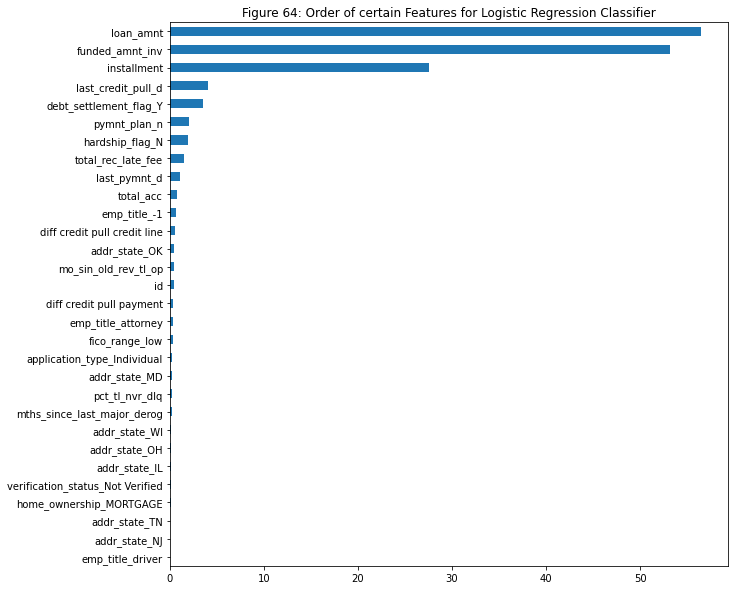

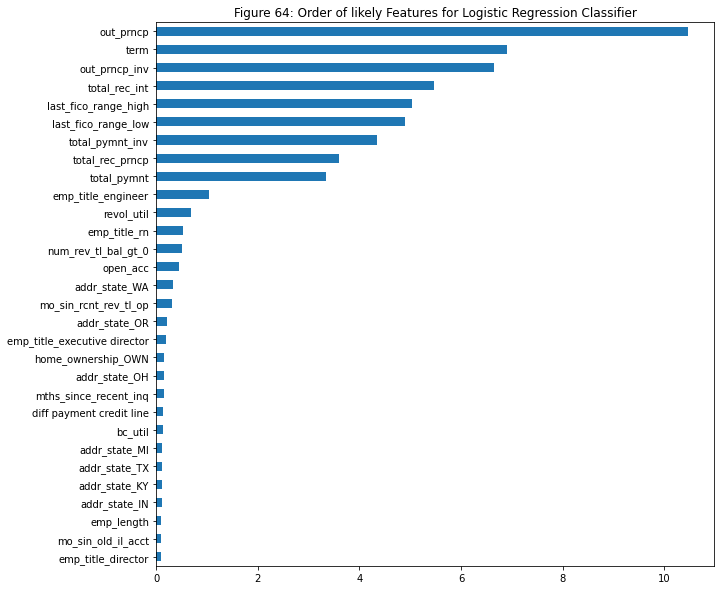

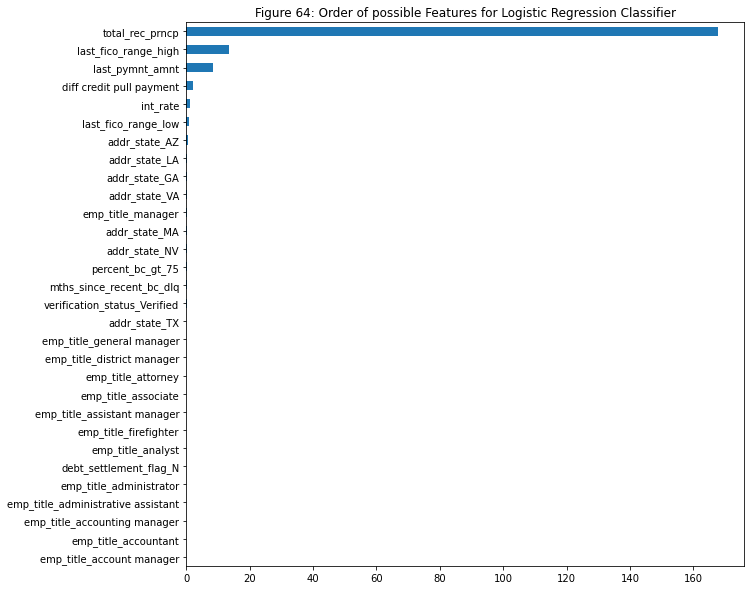

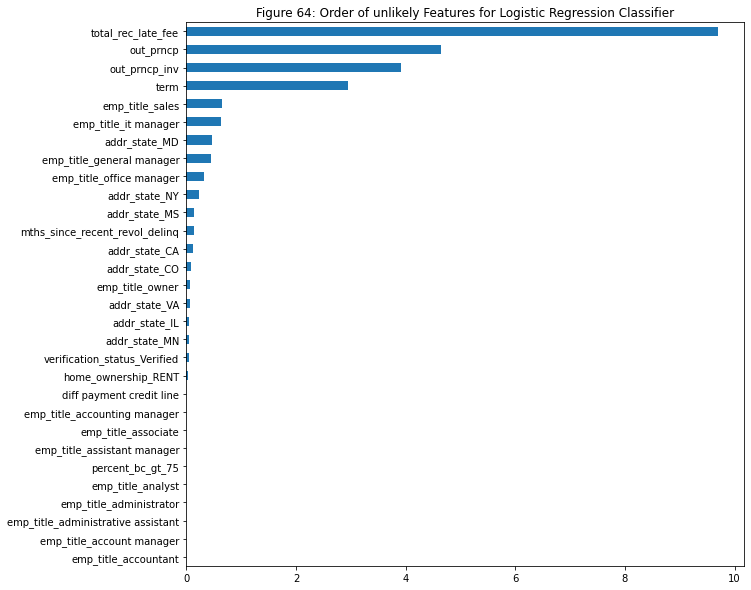

In [44]:
for b,c in enumerate(['certain','likely','possible','unlikely']):
    feature_importances = pd.Series(model4.coef_[b], index=df.columns)
    feature_importances.sort_values()[-30:].plot(kind="barh", figsize=(10,10),
                                       title = "Figure 64: Order of "+c+" Features for Logistic Regression Classifier");
    plt.show()

# For the important features that contribute to the model, only the ones above 0.0015 is included in the subset of the dataset

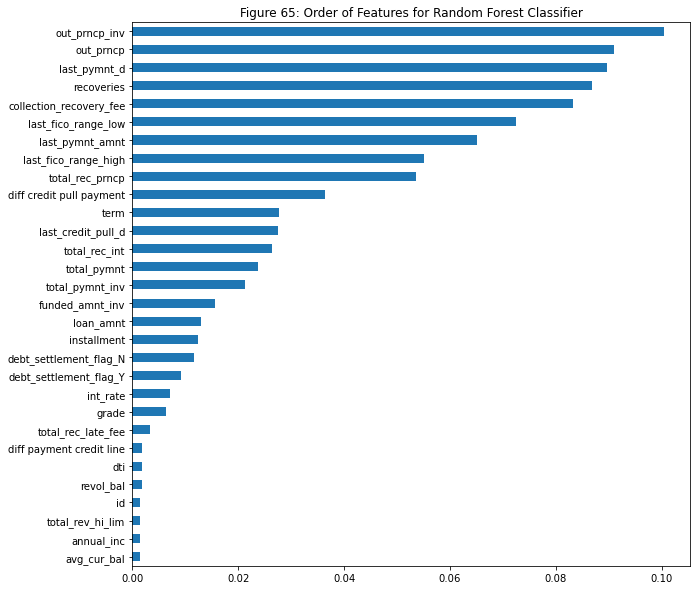

In [45]:
feature_importances = pd.Series(model3.feature_importances_, index=df.columns)
feature_importances.sort_values()[-30:].plot(kind="barh", figsize=(10,10),
                                       title = "Figure 65: Order of Features for Random Forest Classifier");

In [46]:
feature_importances.sort_values()[-29:]

annual_inc                  0.001511
total_rev_hi_lim            0.001511
id                          0.001520
revol_bal                   0.001851
dti                         0.001858
diff payment credit line    0.001879
total_rec_late_fee          0.003359
grade                       0.006336
int_rate                    0.007127
debt_settlement_flag_Y      0.009116
debt_settlement_flag_N      0.011632
installment                 0.012405
loan_amnt                   0.012987
funded_amnt_inv             0.015543
total_pymnt_inv             0.021356
total_pymnt                 0.023656
total_rec_int               0.026341
last_credit_pull_d          0.027415
term                        0.027676
diff credit pull payment    0.036426
total_rec_prncp             0.053586
last_fico_range_high        0.055023
last_pymnt_amnt             0.065148
last_fico_range_low         0.072411
collection_recovery_fee     0.083234
recoveries                  0.086810
last_pymnt_d                0.089739
o

# Once the data is subsetted with just the important variables, the model is ran again to see if the accuracy would increase towards the important features

In [47]:
df = df[feature_importances.sort_values()[-29:].index]
df

,annual_inc,total_rev_hi_lim,id,revol_bal,dti,diff payment credit line,total_rec_late_fee,grade,int_rate,debt_settlement_flag_Y,...,diff credit pull payment,total_rec_prncp,last_fico_range_high,last_pymnt_amnt,last_fico_range_low,collection_recovery_fee,recoveries,last_pymnt_d,out_prncp,out_prncp_inv
0,0.006111,0.005666,0.996940,0.001695,0.00691,0.664560,8.649259e-12,0.382353,0.366286,0.0,...,0.521955,0.102857,0.663529,0.003379,0.662722,0.0,0.0,0.999917,0.000000,0.000000
1,0.007222,0.068117,0.996179,0.013165,0.01706,0.675050,8.649259e-12,0.294118,0.281791,0.0,...,0.882398,0.705714,0.822353,0.025514,0.822485,0.0,0.0,0.998638,0.000000,0.000000
2,0.007000,0.008530,0.995985,0.004825,0.01178,0.678264,8.649259e-12,0.235294,0.230672,0.0,...,0.743032,0.571429,0.828235,0.435544,0.828402,0.0,0.0,0.999133,0.000000,0.000000
3,0.012222,0.041004,0.966360,0.004784,0.01806,0.616036,8.649259e-12,0.411765,0.402619,0.0,...,0.510118,0.545781,0.798824,0.022858,0.798817,0.0,0.0,0.999959,0.700577,0.700577
4,0.011604,0.020715,0.997954,0.013447,0.02637,0.690402,8.649259e-12,0.735294,0.723701,0.0,...,0.731577,0.297143,0.828235,0.278981,0.828402,0.0,0.0,0.998679,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199993,0.008778,0.015293,0.816843,0.014690,0.01674,0.718687,8.649259e-12,0.294118,0.294466,0.0,...,0.592974,0.114286,0.804706,0.010941,0.804734,0.0,0.0,0.999629,0.000000,0.000000
199994,0.009444,0.016024,0.817145,0.013206,0.01082,0.634628,8.649259e-12,0.323529,0.311365,0.0,...,0.511264,0.342857,0.845882,0.210610,0.846154,0.0,0.0,0.998432,0.000000,0.000000
199995,0.008889,0.014683,0.814654,0.012660,0.01462,0.678264,3.188390e-02,0.294118,0.294466,0.0,...,0.511264,0.600000,0.734118,0.018569,0.733728,0.0,0.0,0.999711,0.000000,0.000000
199996,0.006111,0.011272,0.792847,0.003521,0.01723,0.648359,8.649259e-12,0.411765,0.394170,0.0,...,0.488354,0.785714,0.822353,0.434945,0.822485,0.0,0.0,0.998514,0.000000,0.000000


# The metrics of the prediction is very good if not better with just the important features for less overfitting

In [48]:
model5 = RandomForestClassifier(random_state=2, n_jobs=-1)

for train_idx, test_idx in skf.split(df, y):
    model5.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],model5.predict(df.loc[test_idx])))

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11697
           Current       0.97      0.99      0.98      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       115
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.96      0.81      0.88       262

          accuracy                           0.99     66666
         macro avg       0.66      0.63      0.64     66666
      weighted avg       0.99      0.99      0.99     66666

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11696
           Current       0.97      0.99      0.98      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       116
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.95      0

# These are the important features ordered by importance

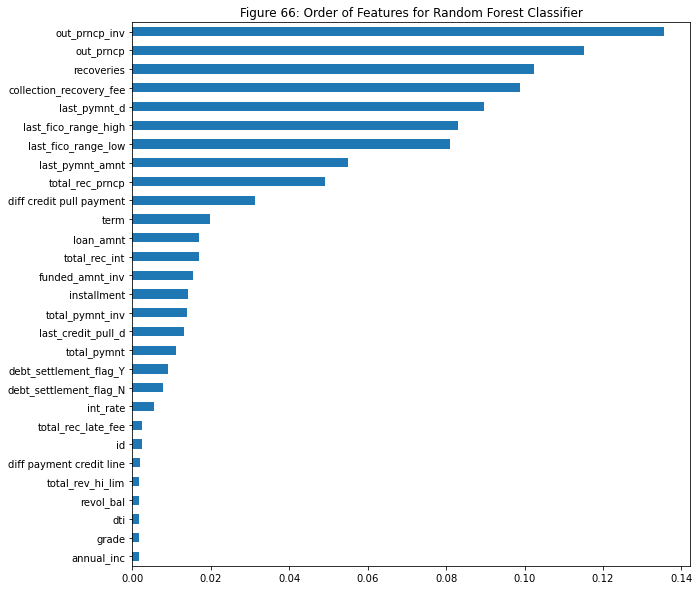

In [49]:
feature_importances = pd.Series(model5.feature_importances_, index=df.columns)
feature_importances.sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 66: Order of Features for Random Forest Classifier");

# The overall problem with random forest coefficients is that they are all positive so both debt settlement yes and no contribute towards the accurate prediction without realizing which feature is negatively or positively contributing towards the prediction, but these metrics is what the company should pull in regards to if a person will pay a loan and the model would determine what category of loan status the person would be in

In [50]:
feature_importances.sort_values()

annual_inc                  0.001619
grade                       0.001634
dti                         0.001741
revol_bal                   0.001794
total_rev_hi_lim            0.001795
diff payment credit line    0.001846
id                          0.002417
total_rec_late_fee          0.002418
int_rate                    0.005609
debt_settlement_flag_N      0.007780
debt_settlement_flag_Y      0.009154
total_pymnt                 0.011034
last_credit_pull_d          0.013124
total_pymnt_inv             0.013795
installment                 0.014062
funded_amnt_inv             0.015527
total_rec_int               0.016861
loan_amnt                   0.017084
term                        0.019709
diff credit pull payment    0.031190
total_rec_prncp             0.049074
last_pymnt_amnt             0.054992
last_fico_range_low         0.081046
last_fico_range_high        0.082950
last_pymnt_d                0.089769
collection_recovery_fee     0.098753
recoveries                  0.102494
o

# Fit the truncated dataset with hyperparameter optimization using gridsearch on the random forest model. The accuracy and other metrics are already very good.


In [51]:
hyperparameters = {'max_features': ['auto', 'sqrt', 'log2'],
                   'min_samples_split': [2,3,4]                   
                  }
rfc = RandomForestClassifier(criterion='entropy', n_jobs=-1, random_state=2, n_estimators=100)

search = GridSearchCV(rfc, hyperparameters, cv=3, scoring='accuracy',
                               verbose=3)

search.fit(df.loc[train_idx],y.loc[train_idx])

print(search.best_estimator_)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3] END max_features=auto, min_samples_split=2;, score=0.991 total time=  16.7s
[CV 2/3] END max_features=auto, min_samples_split=2;, score=0.993 total time=  11.1s
[CV 3/3] END max_features=auto, min_samples_split=2;, score=0.993 total time=  10.9s
[CV 1/3] END max_features=auto, min_samples_split=3;, score=0.992 total time=  10.8s
[CV 2/3] END max_features=auto, min_samples_split=3;, score=0.993 total time=  11.0s
[CV 3/3] END max_features=auto, min_samples_split=3;, score=0.992 total time=  10.9s
[CV 1/3] END max_features=auto, min_samples_split=4;, score=0.991 total time=  10.6s
[CV 2/3] END max_features=auto, min_samples_split=4;, score=0.993 total time=  10.8s
[CV 3/3] END max_features=auto, min_samples_split=4;, score=0.993 total time=  10.8s
[CV 1/3] END max_features=sqrt, min_samples_split=2;, score=0.991 total time=  10.5s
[CV 2/3] END max_features=sqrt, min_samples_split=2;, score=0.993 total time=  10.9s
[CV 3

# The best parameter for random forest classifier is entropy, 3 sample split, and auto, which is then plugged in to retrieve the metrics with the subset important features of the dataset

In [52]:
rfc = search.best_estimator_

for train_idx, test_idx in skf.split(df, y):
    rfc.fit(df.loc[train_idx],y.loc[train_idx])
    print(classification_report(y.loc[test_idx],rfc.predict(df.loc[test_idx])))

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11697
           Current       0.97      0.99      0.98      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       115
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.97      0.79      0.87       262

          accuracy                           0.99     66666
         macro avg       0.66      0.63      0.64     66666
      weighted avg       0.99      0.99      0.99     66666

                    precision    recall  f1-score   support

       Charged Off       1.00      0.99      0.99     11696
           Current       0.97      0.99      0.98      7546
        Fully Paid       1.00      1.00      1.00     46997
   In Grace Period       0.00      0.00      0.00       116
 Late (16-30 days)       0.00      0.00      0.00        49
Late (31-120 days)       0.95      0

# These are the most important features for the best model towards prediction of loan status

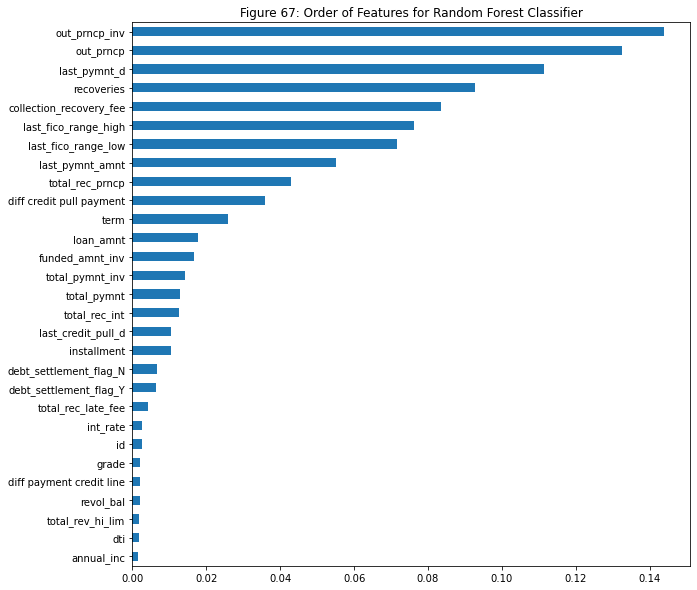

In [53]:
feature_importances = pd.Series(rfc.feature_importances_, index=df.columns)
feature_importances.sort_values().plot(kind="barh", figsize=(10,10),
                                       title = "Figure 67: Order of Features for Random Forest Classifier");

# Using a confusion matrix, here is the normalized and non-normalized labeling of the random forest classifier prediction label compared to the actual label. Type 1 error is a false positive depicted in the upper right of the diagonal while type 2 error is a false negative depicted in the bottom left of the diagonal. Given that loan companies make money off interest if people don't pay on time, they are more concerned if a person is labeled to not pay but pays on time, which would affect the bottom line and is a type 2 error. If a person if labeled as a someone who would pay but does not, that would be benefitial for the loan company to earn interest on the loan, which is a type 1 error.

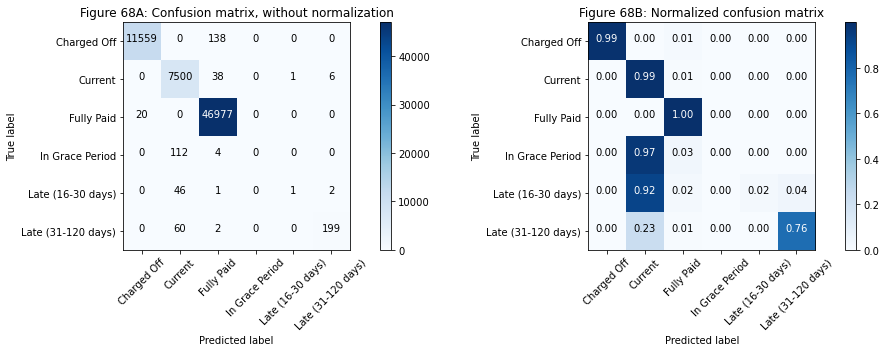

In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y.loc[test_idx],rfc.predict(df.loc[test_idx]))
np.set_printoptions(precision=2)

class_names = ['Charged Off', 'Current', 'Fully Paid', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']

# Plot non-normalized confusion matrix
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Figure 68A: Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(1, 2, 2)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Figure 68B: Normalized confusion matrix')

plt.tight_layout()
plt.show()

# Even though the grace period and late are mislabeled by the confusion matrix, the target variable of Charged off is 0.99, along with fully paid and current at 0.99 and 1.00 in prediction accuracy, respectively

In [55]:
feature_list = list(df.columns)

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rfc.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# here is a graphic of random forest showing the decision trees in which a label is chosen from the dataset

In [56]:
# Limit depth of tree to 3 levels
rf_small = RandomForestClassifier(n_estimators=10, max_depth = 3)
rf_small.fit(df,y)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

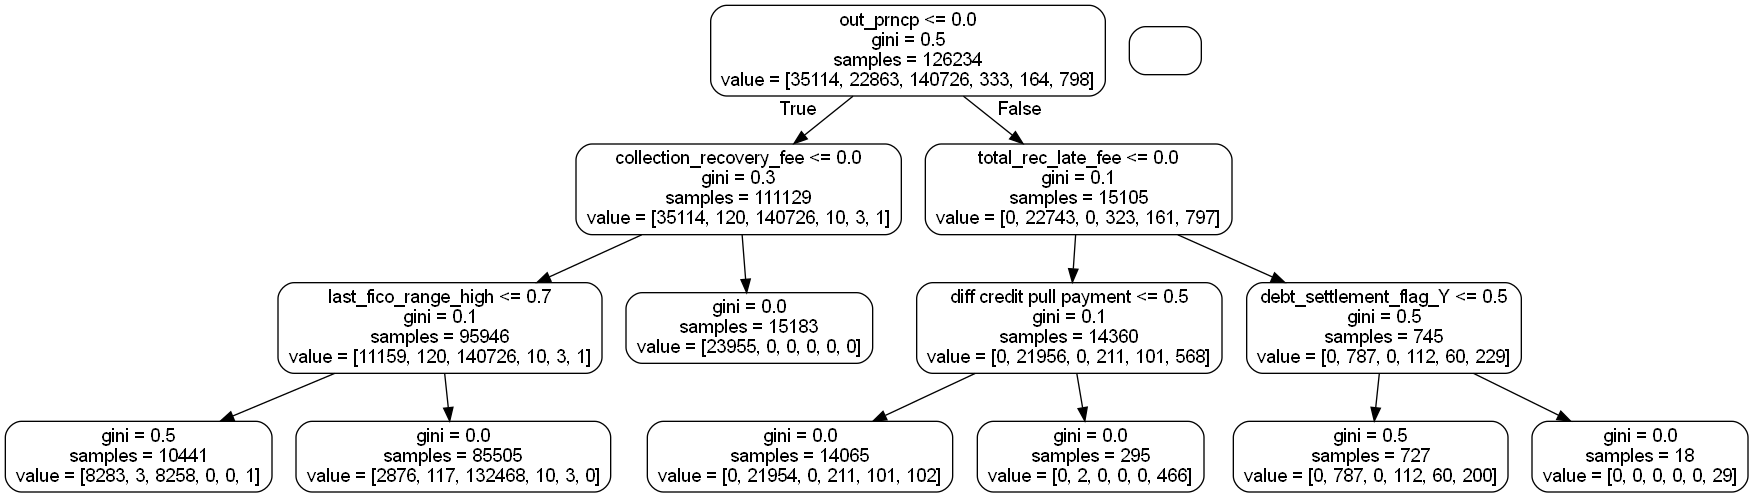

In [57]:
display(Image.open('small_tree.png'))

# if a new people with the same data columns were to be added to the dataset with no label of their loan status, I could use the model to predict their label given that the accuracy of the model is already very high